# check for TOC

In [1]:
import pymupdf
import os

base_folder = "/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/"

files_with_toc = []
files_without_toc = []

for root, dirs, files in os.walk(base_folder):
    for file in files:
        if file.endswith(".pdf"):
            file_path = os.path.join(root, file)
            doc = pymupdf.open(file_path)
            toc = doc.get_toc()
            if len(toc) > 0:
                files_with_toc.append({"path": file_path, "toc": toc})
            else:
                files_without_toc.append(file_path)
            # print(f"TOC for {file_path}:")
            # print(toc)

In [2]:
len(files_with_toc)

43

In [3]:
len(files_without_toc)

37

# Work with the TOC

In [4]:
import pymupdf

doc = pymupdf.open("/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berlinovo/Finanzbericht_Berlinovo_2022_bf_s.pdf")
toc = doc.get_toc()
toc

[[1, 'Überblick', 3],
 [1, 'Unternehmen', 4],
 [2, 'Grußwort der\xa0Geschäftsführung', 5],
 [3, 'Bericht des Aufsichtsrats für das Geschäftsjahr 2022', 7],
 [3, 'Organe', 11],
 [3, 'Corporate Governance', 12],
 [1, 'Konzernlagebericht', 13],
 [2, 'Grundlagen des Unternehmens', 14],
 [3, 'Wirtschafts\xadbericht', 21],
 [3, 'Geschäfts\xadverlauf', 24],
 [3, 'Chancen und Risiken der künftigen Entwicklung', 33],
 [3, 'Prognose\xadbericht', 39],
 [3, 'Angaben zum Berliner Corporate Governance Kodex', 40],
 [1, 'Konzernabschluss', 41],
 [2, 'Konzern\xadbilanz', 42],
 [3, 'Konzern-\xadGewinn- und Verlustrechnung', 44],
 [3, 'Konzern-Eigenkapitalspiegel ', 45],
 [3, 'Konzernkapitalflussrechnung', 47],
 [3, 'Konzernanhang für das Geschäftsjahr 2022', 48],
 [3, 'Anlage I Anlagenspiegel', 66],
 [3, 'Anlage II Anteilsbesitzliste', 67],
 [1, 'Informationen', 72],
 [2, 'Personal\xadangaben', 73],
 [3, 'Portfolioangaben', 74],
 [3, 'Kontakt und Impressum', 79]]

In [5]:
import pandas as pd

def enumerate_toc(hierarchy_levels):
    enumeration = []
    stack = []
    for level in hierarchy_levels:
        # Adjust stack to current level
        while len(stack) > level:
            stack.pop()
        if len(stack) < level:
            stack += [0] * (level - len(stack))
        # Increment current level
        stack[-1] += 1
        # Reset lower levels
        for i in range(level, len(stack)):
            stack[i] = 0
        # Build enumeration string
        enum_str = ".".join(str(num) for num in stack if num > 0)
        enumeration.append(enum_str)
    return enumeration

def generate_markdown_toc(toc):
    toc_df = pd.DataFrame(toc, columns=["hierarchy_level", "title", "page_number"])
    toc_df["enumeration"] = enumerate_toc(toc_df["hierarchy_level"].tolist())
    toc_markdown = toc_df.to_markdown(index=False)
    return toc_markdown

for item in files_with_toc:
    item['n_entries'] = len(item['toc'])
    item['markdown_toc'] = generate_markdown_toc(item['toc'])

files_with_toc

[{'path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf',
  'toc': [[1, 'Lagebericht', 5],
   [1, 'Bilanz', 7],
   [1, 'Gewinn- und Verlustrechnung', 10],
   [1, 'Anhang', 13],
   [1, 'Lagebericht ', 17],
   [1, 'Bilanz', 25],
   [1, 'Anhang', 31],
   [1, 'Anlagenspiegel', 39],
   [1, 'Bestätigungsvermerk', 42]],
  'n_entries': 9,
  'markdown_toc': '|   hierarchy_level | title                       |   page_number |   enumeration |\n|------------------:|:----------------------------|--------------:|--------------:|\n|                 1 | Lagebericht                 |             5 |             1 |\n|                 1 | Bilanz                      |             7 |             2 |\n|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |\n|                 1 | Anhang                      |            13 |             4 |\n|                 1 | Lagebericht                 |            17 |         

In [6]:
import json

toc_data = {
    "files_with_toc": files_with_toc,
    "files_without_toc": files_without_toc
}

with open("../../benchmark_results/page_identification/toc_data.json", "w") as f:
    json.dump(toc_data, f, indent=4)


In [9]:
toc_markdown = toc_data["files_with_toc"][0]["markdown_toc"]
print(toc_markdown)

|   hierarchy_level | title                       |   page_number |   enumeration |
|------------------:|:----------------------------|--------------:|--------------:|
|                 1 | Lagebericht                 |             5 |             1 |
|                 1 | Bilanz                      |             7 |             2 |
|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |
|                 1 | Anhang                      |            13 |             4 |
|                 1 | Lagebericht                 |            17 |             5 |
|                 1 | Bilanz                      |            25 |             6 |
|                 1 | Anhang                      |            31 |             7 |
|                 1 | Anlagenspiegel              |            39 |             8 |
|                 1 | Bestätigungsvermerk         |            42 |             9 |


In [8]:
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:8000/v1",
    api_key="sk-1234567890abcdef1234567890abcdef1234567890abcdef1234567890abcdef",
)

models = client.models.list()
model = models.data[0].id
print(f"Using model: {model}")

Using model: mistralai/Ministral-8B-Instruct-2410


## simple request

In [ ]:
def combine_messages(messages):
    """
    Combines subsequent dicts in a list with the same 'role' by joining their 'content' strings.
    Args:
        messages (list of dict): Each dict must have 'role' and 'content' keys.
    Returns:
        list of dict: Combined messages.
    """
    if not messages:
        return []

    combined = [messages[0].copy()]
    for msg in messages[1:]:
        if msg["role"] == combined[-1]["role"]:
            combined[-1]["content"] += "\n" + msg["content"]
        else:
            combined.append(msg.copy())
    return combined

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page is the win and loss statement (in German: Gewinn- und Verlustrechnung) located?"},
    {"role": "assistant", "content": f"The win and loss statement can be found on page "}
]

In [ ]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    # extra_body={
    #     "guided_grammar": ebnf_grammar,
    #     # 'use_beam_search': True
    # },
    max_tokens=1000,
    temperature=0.2,
)

result = completion.choices[0].message.content

In [16]:
result

'The win and loss statement (Gewinn- und Verlustrechnung) is located on page 10.'

In [22]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page is the balance sheets (in German: Bilanz) located? Give seperate answers for the liabilities and assets table."},
    {"role": "assistant", "content": f"The balance sheet can be found on the pages "}
]

In [23]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    # extra_body={
    #     "guided_grammar": ebnf_grammar,
    #     # 'use_beam_search': True
    # },
    max_tokens=1000,
    temperature=0.2,
)

result = completion.choices[0].message.content

In [24]:
result

'The balance sheet (Bilanz) is located on the following pages:\n\n- Liabilities and Assets Table: Page 7\n- Liabilities and Assets Table: Page 25'

In [25]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page are the win and loss statement (in German: Gewinn- und Verlustrechnung) and the balance sheets (German: Bilanz) located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    {"role": "user", "content": f"Answer in JSON format with keys 'liabilities', 'assets', and 'win_loss_statement' and the page numbers as values."},
]
combine_messages(messages)

[{'role': 'system',
  'content': 'You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents.'},
 {'role': 'user',
  'content': "This is the table of contents:\n\n|   hierarchy_level | title                       |   page_number |   enumeration |\n|------------------:|:----------------------------|--------------:|--------------:|\n|                 1 | Lagebericht                 |             5 |             1 |\n|                 1 | Bilanz                      |             7 |             2 |\n|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |\n|                 1 | Anhang                      |            13 |             4 |\n|                 1 | Lagebericht                 |            17 |             5 |\n|                 1 | Bilanz                      |            25 |             6 |\n|                 1 | Anhang                      |     

In [26]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    # extra_body={
    #     "guided_grammar": ebnf_grammar,
    #     # 'use_beam_search': True
    # },
    max_tokens=1000,
    temperature=0.2,
)

result = completion.choices[0].message.content

In [27]:
result

'{\n  "assets": 7,\n  "liabilities": 7,\n  "win_loss_statement": 10\n}'

## structured generation

In [28]:
from pydantic import BaseModel
# from enum import Enum

# class CarType(str, Enum):
#     sedan = "sedan"
#     suv = "SUV"
#     truck = "Truck"
#     coupe = "Coupe"

class TOCEntry(BaseModel):
    title: str
    page: int

class TOC(BaseModel):
    entries: list[TOCEntry]

json_schema = TOC.model_json_schema()
json_schema

{'$defs': {'TOCEntry': {'properties': {'title': {'title': 'Title',
     'type': 'string'},
    'page': {'title': 'Page', 'type': 'integer'}},
   'required': ['title', 'page'],
   'title': 'TOCEntry',
   'type': 'object'}},
 'properties': {'entries': {'items': {'$ref': '#/$defs/TOCEntry'},
   'title': 'Entries',
   'type': 'array'}},
 'required': ['entries'],
 'title': 'TOC',
 'type': 'object'}

In [33]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    extra_body={
        "response_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "toc",
                "schema": json_schema
            },
        },
    },
    max_tokens=1000,
    temperature=0,
)

result = completion.choices[0].message.content


In [34]:
result

'{\n  "entries": [\n    {\n      "title": "Gewinn- und Verlustrechnung",\n      "page": 10\n    },\n    {\n      "title": "Bilanz",\n      "page": 7\n    }\n  ]\n}'

In [35]:
from pydantic import BaseModel


class TOC(BaseModel):
    GuV: int
    Aktiva: int
    Passiva: int

json_schema = TOC.model_json_schema()
json_schema

{'properties': {'GuV': {'title': 'Guv', 'type': 'integer'},
  'Aktiva': {'title': 'Aktiva', 'type': 'integer'},
  'Passiva': {'title': 'Passiva', 'type': 'integer'}},
 'required': ['GuV', 'Aktiva', 'Passiva'],
 'title': 'TOC',
 'type': 'object'}

In [36]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page are the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (German: Bilanz) located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page numbers as values."},
]

In [40]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    extra_body={
        "response_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "toc",
                "schema": json_schema
            },
        },
    },
    max_tokens=1000,
    temperature=0,
)

result = completion.choices[0].message.content


In [41]:
result

'{\n  "GuV": 10,\n  "Aktiva": 7,\n  "Passiva": 7\n}'

### page ranges

In [42]:
from pydantic import BaseModel

class PageRange(BaseModel):
    start: int
    end: int

class TOC(BaseModel):
    GuV: PageRange
    Aktiva: PageRange
    Passiva: PageRange

json_schema = TOC.model_json_schema()
json_schema

{'$defs': {'PageRange': {'properties': {'start': {'title': 'Start',
     'type': 'integer'},
    'end': {'title': 'End', 'type': 'integer'}},
   'required': ['start', 'end'],
   'title': 'PageRange',
   'type': 'object'}},
 'properties': {'GuV': {'$ref': '#/$defs/PageRange'},
  'Aktiva': {'$ref': '#/$defs/PageRange'},
  'Passiva': {'$ref': '#/$defs/PageRange'}},
 'required': ['GuV', 'Aktiva', 'Passiva'],
 'title': 'TOC',
 'type': 'object'}

In [43]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    {"role": "user", "content": f"The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
    {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
]

In [44]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    extra_body={
        "response_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "toc",
                "schema": json_schema
            },
        },
    },
    max_tokens=1000,
    logprobs=1,
    temperature=0,
)

result = completion.choices[0].message.content
logprobs = getattr(completion.choices[0], "logprobs", None)


In [45]:
result

'{\n  "GuV": {\n    "start": 10,\n    "end": 10\n  },\n  "Aktiva": {\n    "start": 7,\n    "end": 7\n  },\n  "Passiva": {\n    "start": 7,\n    "end": 7\n  }\n}'

In [59]:
import numpy as np

def calculate_confidence(log_probs):
    return np.exp(np.sum(log_probs))

# def calculate_confidence_linear_probs(log_probs):
#     linear_probs = np.round(np.exp(log_probs)*100,2)
#     confidence = np.mean(linear_probs)
#     return confidence

In [51]:
# token_logprobs = np.array([t.logprob for t in logprobs.content])
# confidence = calculate_confidence_linear_probs(token_logprobs)
# confidence

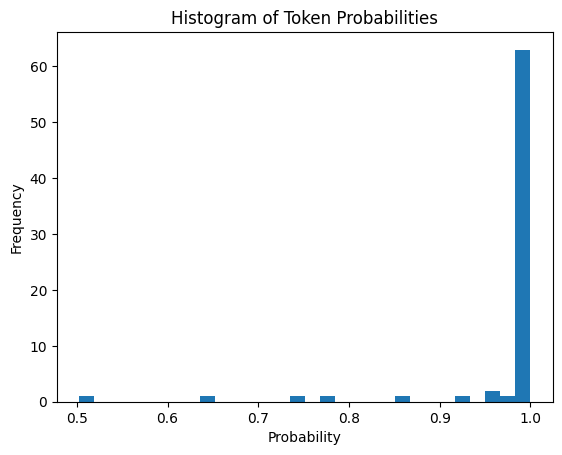

In [48]:
import matplotlib.pyplot as plt

plt.hist(np.exp(token_logprobs), bins=30)
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Histogram of Token Probabilities")
plt.show()

In [52]:
import numpy as np

# Concatenate all tokens to reconstruct the generated text
tokens = [t.token for t in logprobs.content]
generated_text = ''.join(tokens)

# Find logprobs for tokens that are numbers
number_logprobs = []
numbers = []
for t in logprobs.content:
    # Check if the token is a number (integer)
    if t.token.strip().isdigit():
        number_logprobs.append(t.logprob)
        numbers.append(t.token.strip())

[str(number)+": "+str(conf) for conf, number in zip(np.exp(number_logprobs), numbers)]

['1: 0.9850110220817944',
 '0: 0.9943485788648945',
 '1: 0.9783530013961784',
 '0: 0.738269956440733',
 '7: 0.7773805787144588',
 '7: 0.8665902178471487',
 '7: 0.5028879267914775',
 '7: 0.9213157019901284']

In [53]:
tokens_logprobs = [(t.token, t.logprob) for t in logprobs.content]
tokens_logprobs

digit_list = []

for token, logprob in tokens_logprobs:
    if token.strip().isdigit():
        digit_list.append((token, logprob))
    else:
        digit_logprobs = [t[1] for t in digit_list]
        number = [t[0] for t in digit_list]
        if digit_logprobs:
            print(str(number)+": "+str(digit_logprobs))
            confidence = calculate_confidence(np.array(digit_logprobs))
            print(f"Confidence: {confidence}")
        digit_list = []



['1', '0']: [-0.0151024479418993, -0.005667450837790966]
Confidence: 0.9794443099732894
['1', '0']: [-0.021884731948375702, -0.3034457266330719]
Confidence: 0.722288627724417
['7']: [-0.2518252432346344]
Confidence: 0.7773805787144588
['7']: [-0.14318905770778656]
Confidence: 0.8665902178471487
['7']: [-0.6873879432678223]
Confidence: 0.5028879267914775
['7']: [-0.0819525197148323]
Confidence: 0.9213157019901284


In [58]:
grouped_confidences = []
for i in range(0, len(number_logprobs), 2):
    group = number_logprobs[i:i+2]
    confidence = calculate_confidence(np.array(group))
    grouped_confidences.append(confidence)

grouped_confidences

[np.float64(0.9794443099732894),
 np.float64(0.722288627724417),
 np.float64(0.6736704050583053),
 np.float64(0.46331854329425043)]

In [57]:
generated_text

'{ĊĠĠ"GuV":Ġ{ĊĠĠĠĠ"start":Ġ10,ĊĠĠĠĠ"end":Ġ10ĊĠĠ},ĊĠĠ"Aktiva":Ġ{ĊĠĠĠĠ"start":Ġ7,ĊĠĠĠĠ"end":Ġ7ĊĠĠ},ĊĠĠ"Passiva":Ġ{ĊĠĠĠĠ"start":Ġ7,ĊĠĠĠĠ"end":Ġ7ĊĠĠ}Ċ}</s>'

## looping

In [64]:
import json

def calculate_confidence_for_integers(log_probs):
    tokens_logprobs = [(t.token, t.logprob) for t in log_probs.content]

    digit_list = []
    confidence_scores = []

    for token, logprob in tokens_logprobs:
        if token.strip().isdigit():
            digit_list.append((token, logprob))
        else:
            digit_logprobs = [t[1] for t in digit_list]
            number = [t[0] for t in digit_list]
            if digit_logprobs:
                # print(str(number)+": "+str(digit_logprobs))
                confidence = calculate_confidence(np.array(digit_logprobs))
                # print(f"Confidence: {confidence}")
                # Convert list of digit tokens to a single integer
                number_str = ''.join(number)
                confidence_scores.append({"number": int(number_str), "confidence": confidence})
            digit_list = []

    return confidence_scores

page_range_result = []

for idx, entry in enumerate(files_with_toc):
    print(f"Processing file {idx + 1}/{len(files_with_toc)}:")
    toc_markdown = pd.DataFrame(entry["toc"], columns=["hierarchy_level", "title", "page_number"]).to_markdown(index=False)

    messages = [
        {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
        {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
        {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
        {"role": "user", "content": f"The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
        {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=combine_messages(messages),
        extra_body={
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "toc",
                    "schema": json_schema
                },
            },
        },
        max_tokens=1000,
        logprobs=1,
        temperature=0,
    )

    result = completion.choices[0].message.content
    result_json = json.loads(result)
    result_json["file_path"] = entry["path"]

    logprobs = getattr(completion.choices[0], "logprobs", None)
    digit_logprobs = calculate_confidence_for_integers(logprobs) if logprobs else None
    result_json["logprobs"] = {'GuV': digit_logprobs[0:2], 'Aktiva': digit_logprobs[2:4], 'Passiva': digit_logprobs[4:]}

    page_range_result.append(result_json)


Processing file 1/43:
Processing file 2/43:
Processing file 3/43:
Processing file 4/43:
Processing file 5/43:
Processing file 6/43:
Processing file 7/43:
Processing file 8/43:
Processing file 9/43:
Processing file 10/43:
Processing file 11/43:
Processing file 12/43:
Processing file 13/43:
Processing file 14/43:
Processing file 15/43:
Processing file 16/43:
Processing file 17/43:
Processing file 18/43:
Processing file 19/43:
Processing file 20/43:
Processing file 21/43:
Processing file 22/43:
Processing file 23/43:
Processing file 24/43:
Processing file 25/43:
Processing file 26/43:
Processing file 27/43:
Processing file 28/43:
Processing file 29/43:
Processing file 30/43:
Processing file 31/43:
Processing file 32/43:
Processing file 33/43:
Processing file 34/43:
Processing file 35/43:
Processing file 36/43:
Processing file 37/43:
Processing file 38/43:
Processing file 39/43:
Processing file 40/43:
Processing file 41/43:
Processing file 42/43:
Processing file 43/43:


In [65]:
page_range_result

[{'GuV': {'start': 10, 'end': 10},
  'Aktiva': {'start': 7, 'end': 7},
  'Passiva': {'start': 7, 'end': 7},
  'file_path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf',
  'logprobs': {'GuV': [{'number': 10,
     'confidence': np.float64(0.983680062384933)},
    {'number': 10, 'confidence': np.float64(0.6961185335525288)}],
   'Aktiva': [{'number': 7, 'confidence': np.float64(0.7846286070883)},
    {'number': 7, 'confidence': np.float64(0.8274459376114296)}],
   'Passiva': [{'number': 7, 'confidence': np.float64(0.4704749115696667)},
    {'number': 7, 'confidence': np.float64(0.9115476092858914)}]}},
 {'GuV': {'start': 44, 'end': 44},
  'Aktiva': {'start': 42, 'end': 42},
  'Passiva': {'start': 42, 'end': 42},
  'file_path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2017.pdf',
  'logprobs': {'GuV': [{'number': 44,
     'confidence': np.float64(0.9482257399140822)},
    {'number'

In [66]:
df = pd.read_csv("/home/simon/Documents/data_science/Thesis/benchmark_truth/aktiva_passiva_guv_table_pages_no_ocr.csv")
df

,filepath,page,type
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,10,Aktiva
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,11,Passiva
2,../Geschaeftsberichte/Berliner Bäder Betriebe/...,13,GuV
3,../Geschaeftsberichte/Berliner Bäder Betriebe/...,28,Aktiva
4,../Geschaeftsberichte/Berliner Bäder Betriebe/...,29,Passiva
...,...,...,...
247,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,44,GuV
248,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,62,GuV
249,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,52,Aktiva
250,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,53,Passiva


In [67]:
import json

df_result = pd.DataFrame(page_range_result)
df_result['file_path'] = df_result['file_path'].apply(lambda x: x.replace("/home/simon/Documents/data_science/Thesis/", "../"))  # Ensure file_path is string type
# Melt the DataFrame to long format, keeping 'file_path' as id
df_long = df_result.melt(id_vars=["file_path", "logprobs"], var_name="type", value_name="page_range")
df_long["logprobs"] = df_long.apply(lambda x: x.get("logprobs").get(x["type"]) if x.get("logprobs") else None, axis=1)
# Convert the 'page_range' column from JSON string to dict if necessary

# If page_range is already a dict, this will do nothing; otherwise, it will parse the string
# df_long["page_range"] = df_long["page_range"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Split into two new columns
df_long["start_page"] = df_long["page_range"].apply(lambda x: x["start"])
df_long["end_page"] = df_long["page_range"].apply(lambda x: x["end"])
df_long = df_long.drop(columns=["page_range"])
df_long.rename(columns={"file_path": "filepath"}, inplace=True)
df_long["confidence_start_page"] = df_long["logprobs"].apply(lambda x: x[0].get("confidence") if x else None)
df_long["confidence_end_page"] = df_long["logprobs"].apply(lambda x: x[1].get("confidence") if x else None)
df_long = df_long.drop(columns=["logprobs"])

df_long

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.983680,0.696119
1,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,44,44,0.948226,0.798095
2,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,GuV,6,6,0.985528,0.328488
3,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,55,59,0.636677,0.347017
4,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,76,76,0.853781,0.758631
...,...,...,...,...,...,...
124,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,45,47,0.559253,0.789411
125,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,40,40,0.518207,0.974258
126,../Geschaeftsberichte/GESOBAU AG/Gesch%C3%A4ft...,Passiva,39,41,0.873503,0.663166
127,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,40,40,0.572712,0.970848


In [68]:
df_check = df.merge(df_long, on=["filepath", "type"], how="right")
df_check["in_range"] = df_check.apply(lambda row: row["start_page"] <= row["page"] <= row["end_page"], axis=1)
df_check['min_distance'] = df_check.apply(lambda row: min(abs(row["start_page"] - row["page"]), abs(row["end_page"] - row["page"])) if not row["in_range"] else 0, axis=1)

df_check

,filepath,page,type,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,10.0,GuV,10,10,0.983680,0.696119,True,0.0
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,28.0,GuV,10,10,0.983680,0.696119,False,18.0
2,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,44.0,GuV,44,44,0.948226,0.798095,True,0.0
3,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,45.0,GuV,44,44,0.948226,0.798095,False,1.0
4,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,6.0,GuV,6,6,0.985528,0.328488,True,0.0
...,...,...,...,...,...,...,...,...,...
144,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,NaN,Passiva,45,47,0.559253,0.789411,False,NaN
145,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,41.0,Passiva,40,40,0.518207,0.974258,False,1.0
146,../Geschaeftsberichte/GESOBAU AG/Gesch%C3%A4ft...,NaN,Passiva,39,41,0.873503,0.663166,False,NaN
147,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,41.0,Passiva,40,40,0.572712,0.970848,False,1.0


In [69]:
df_check.groupby("in_range").size()

in_range
False    95
True     54
dtype: int64

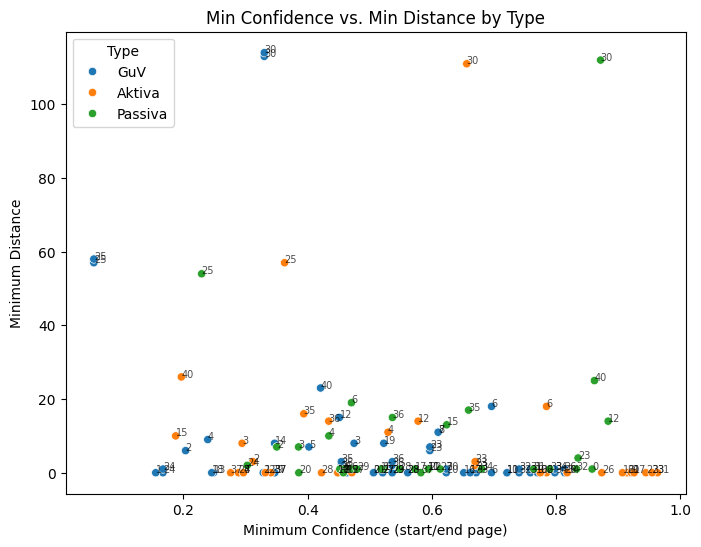

In [70]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the minimum confidence for each row
df_check["min_confidence"] = df_check[["confidence_start_page", "confidence_end_page"]].min(axis=1)
df_check["mean_confidence"] = df_check[["confidence_start_page", "confidence_end_page"]].mean(axis=1)
df_check["max_confidence"] = df_check[["confidence_start_page", "confidence_end_page"]].max(axis=1)
# Assign a unique integer to each unique filepath for annotation or coloring
df_check["path_id"] = df_check["filepath"].astype("category").cat.codes
df_check["min_confidence_path_group"] = df_check.groupby("path_id")["min_confidence"].transform("min")

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_check,  # [~df_check["in_range"]],
    x="min_confidence",
    y="min_distance",
    hue="type",
    palette="tab10"
)

# Annotate each point with the last part of the filepath (e.g., filename)
for i, row in df_check.iterrows():
    plt.text(
        row["min_confidence"],
        row["min_distance"],
        str(row["path_id"]),  # or: os.path.basename(row["filepath"]) if you want the filename
        fontsize=7,
        alpha=0.7
    )
plt.xlabel("Minimum Confidence (start/end page)")
plt.ylabel("Minimum Distance")
plt.title("Min Confidence vs. Min Distance by Type")
plt.legend(title="Type")
plt.show()

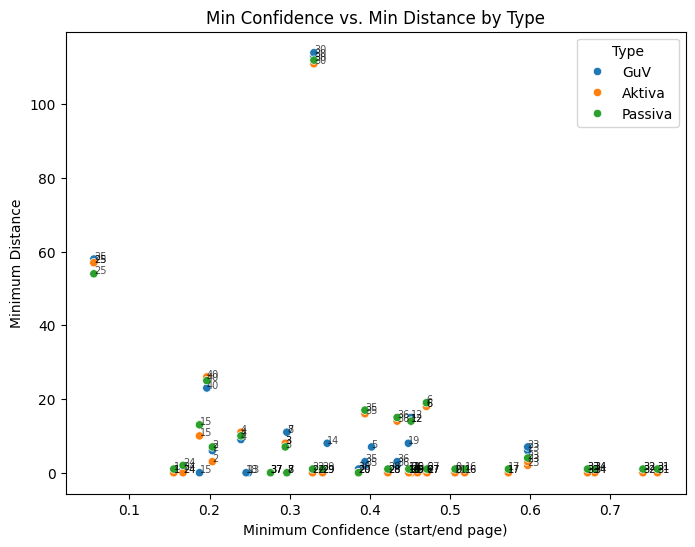

In [71]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_check,  # [~df_check["in_range"]],
    x="min_confidence_path_group",
    y="min_distance",
    hue="type",
    palette="tab10"
)

# Annotate each point with the last part of the filepath (e.g., filename)
for i, row in df_check.iterrows():
    plt.text(
        row["min_confidence_path_group"],
        row["min_distance"],
        str(row["path_id"]),  # or: os.path.basename(row["filepath"]) if you want the filename
        fontsize=7,
        alpha=0.7
    )
plt.xlabel("Minimum Confidence (start/end page)")
plt.ylabel("Minimum Distance")
plt.title("Min Confidence vs. Min Distance by Type")
plt.legend(title="Type")
plt.show()

<Axes: >

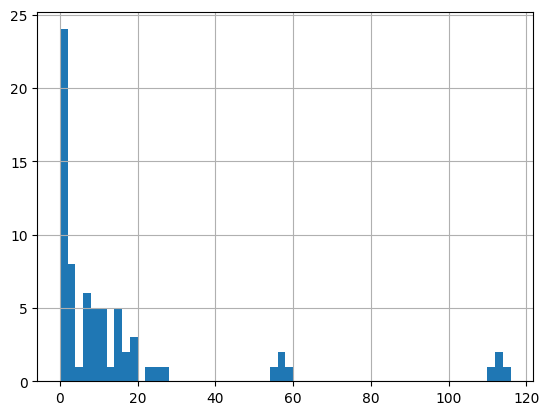

In [72]:
df_check[~df_check["in_range"]]["min_distance"].hist(bins=range(0, int(df_check["min_distance"].max()) + 3, 2))

In [74]:
df_check[df_check['min_distance']>80]

,filepath,page,type,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
17,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,118.0,GuV,5,5,0.416241,0.330158,False,113.0,0.330158,0.373199,0.416241,30,0.330158
18,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,119.0,GuV,5,5,0.416241,0.330158,False,114.0,0.330158,0.373199,0.416241,30,0.330158
70,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,116.0,Aktiva,5,5,0.656186,0.954893,False,111.0,0.656186,0.805539,0.954893,30,0.330158
115,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,117.0,Passiva,5,5,0.871736,0.997955,False,112.0,0.871736,0.934845,0.997955,30,0.330158


In [75]:
df_check[df_check['filepath'].str.contains("../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2012.pdf")]

,filepath,page,type,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
17,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,118.0,GuV,5,5,0.416241,0.330158,False,113.0,0.330158,0.373199,0.416241,30,0.330158
18,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,119.0,GuV,5,5,0.416241,0.330158,False,114.0,0.330158,0.373199,0.416241,30,0.330158
70,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,116.0,Aktiva,5,5,0.656186,0.954893,False,111.0,0.656186,0.805539,0.954893,30,0.330158
115,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,117.0,Passiva,5,5,0.871736,0.997955,False,112.0,0.871736,0.934845,0.997955,30,0.330158


In [76]:
df_check[(df_check['min_distance']<80) & (df_check['min_distance']>20)]

,filepath,page,type,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
23,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,68.0,GuV,10,11,0.055672,0.267806,False,57.0,0.055672,0.161739,0.267806,25,0.055672
24,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,69.0,GuV,10,11,0.055672,0.267806,False,58.0,0.055672,0.161739,0.267806,25,0.055672
49,../Geschaeftsberichte/degewo AG/212131_degewo_...,33.0,GuV,56,56,0.601634,0.420752,False,23.0,0.420752,0.511193,0.601634,40,0.196571
73,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,66.0,Aktiva,8,9,0.362866,0.818178,False,57.0,0.362866,0.590522,0.818178,25,0.055672
94,../Geschaeftsberichte/degewo AG/212131_degewo_...,30.0,Aktiva,56,56,0.196571,0.943644,False,26.0,0.196571,0.570107,0.943644,40,0.196571
118,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,67.0,Passiva,12,13,0.229301,0.945955,False,54.0,0.229301,0.587628,0.945955,25,0.055672
138,../Geschaeftsberichte/degewo AG/212131_degewo_...,31.0,Passiva,56,56,0.861833,0.993195,False,25.0,0.861833,0.927514,0.993195,40,0.196571


In [77]:
df_check.groupby("filepath").size()

filepath
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2014_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2016_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2018_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2019_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2023_BBB.pdf         3
../Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss_2021_BEN_GmbH.pdf                  3
../Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf                                     6
../Geschaeftsberichte/Berlinovo/Finanzbericht_Berlinovo_2022_bf_s.pdf                                   3
../Geschaeftsberichte/Berlinovo/Finanzbericht_Berlinovo_2022_s.pdf                                      3
../Geschaeftsberichte/Berlinovo/berli

In [78]:
df_check[df_check['filepath'].str.contains("../Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf")]

,filepath,page,type,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,10.0,GuV,10,10,0.983680,0.696119,True,0.0,0.696119,0.839899,0.983680,6,0.470475
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,28.0,GuV,10,10,0.983680,0.696119,False,18.0,0.696119,0.839899,0.983680,6,0.470475
60,../Geschaeftsberichte/Berliner Bäder Betriebe/...,7.0,Aktiva,7,7,0.784629,0.827446,True,0.0,0.784629,0.806037,0.827446,6,0.470475
61,../Geschaeftsberichte/Berliner Bäder Betriebe/...,25.0,Aktiva,7,7,0.784629,0.827446,False,18.0,0.784629,0.806037,0.827446,6,0.470475
105,../Geschaeftsberichte/Berliner Bäder Betriebe/...,8.0,Passiva,7,7,0.470475,0.911548,False,1.0,0.470475,0.691011,0.911548,6,0.470475
106,../Geschaeftsberichte/Berliner Bäder Betriebe/...,26.0,Passiva,7,7,0.470475,0.911548,False,19.0,0.470475,0.691011,0.911548,6,0.470475


In [79]:
[entry for entry in files_with_toc if "/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf" in entry["path"]]

[{'path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf',
  'toc': [[1, 'Lagebericht', 5],
   [1, 'Bilanz', 7],
   [1, 'Gewinn- und Verlustrechnung', 10],
   [1, 'Anhang', 13],
   [1, 'Lagebericht ', 17],
   [1, 'Bilanz', 25],
   [1, 'Anhang', 31],
   [1, 'Anlagenspiegel', 39],
   [1, 'Bestätigungsvermerk', 42]],
  'n_entries': 9,
  'markdown_toc': '|   hierarchy_level | title                       |   page_number |   enumeration |\n|------------------:|:----------------------------|--------------:|--------------:|\n|                 1 | Lagebericht                 |             5 |             1 |\n|                 1 | Bilanz                      |             7 |             2 |\n|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |\n|                 1 | Anhang                      |            13 |             4 |\n|                 1 | Lagebericht                 |            17 |         

In [116]:
df_multientries = pd.DataFrame(df_check.groupby("filepath").size(), columns=['count']).reset_index().query("count > 4").reset_index()
df_multientries

,index,filepath,count
0,6,../Geschaeftsberichte/Berliner Bäder Betriebe/...,6
1,23,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,5


In [117]:
df_check[~df_check['filepath'].isin(df_multientries['filepath'])].groupby("in_range").size()

in_range
False    86
True     52
dtype: int64

In [104]:
small_toc = [file['path'].replace("/home/simon/Documents/data_science/Thesis", "..") for file in files_with_toc if file['n_entries'] <= 3]
small_toc

['../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2012.pdf',
 '../Geschaeftsberichte/Berlinovo/berlinovo_gb2019_s.pdf',
 '../Geschaeftsberichte/degewo AG/2019_degewo_Konzernbericht_und_Gleicher_Lohn_fuer_gleiche_Arbeit.pdf',
 '../Geschaeftsberichte/degewo AG/212131_degewo_2022_Konzernlagebericht_Konzernabschluss.pdf',
 '../Geschaeftsberichte/degewo AG/201231_degewo_Konzernlagebericht_Konzernabschluss.pdf',
 '../Geschaeftsberichte/degewo AG/240618-degewo-konzernlagerbericht-konzernabschluss-2023.pdf',
 '../Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss_2021_BEN_GmbH.pdf']

<Axes: xlabel='i'>

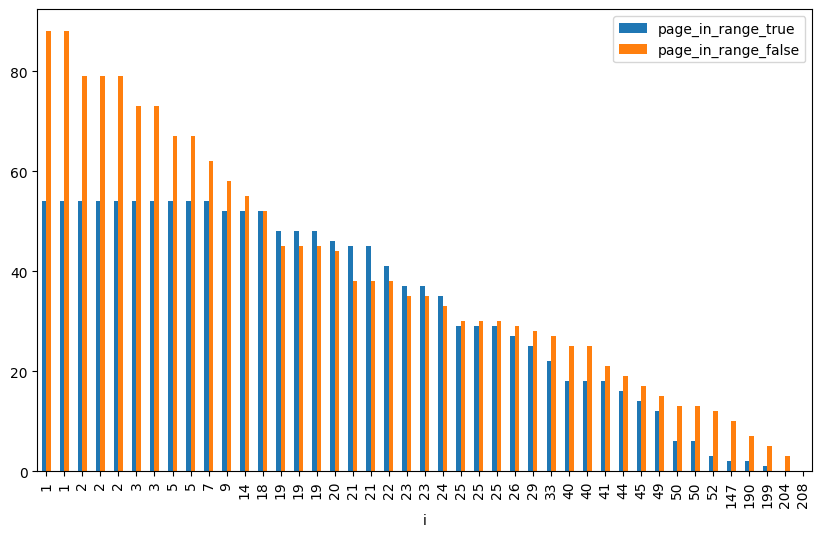

In [114]:
list = []

for i in [file['n_entries'] for file in files_with_toc]:
    small_toc = [file['path'].replace("/home/simon/Documents/data_science/Thesis", "..") for file in files_with_toc if file['n_entries'] <= i]
    page_in_range = df_check[~df_check['filepath'].isin(small_toc)].groupby("in_range").size()
    list.append({
        "i": i,
        "page_in_range_true": page_in_range.get(True, 0),
        "page_in_range_false": page_in_range.get(False, 0)
    })
    # print(f"i: {i}, page_in_range: {page_in_range}")

pd.DataFrame(list).sort_values(by="i", ascending=True).set_index("i").plot(kind="bar", figsize=(10, 6))

In [115]:
df_check

,filepath,page,type,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,10.0,GuV,10,10,0.983680,0.696119,True,0.0,0.696119,0.839899,0.983680,6,0.470475
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,28.0,GuV,10,10,0.983680,0.696119,False,18.0,0.696119,0.839899,0.983680,6,0.470475
2,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,44.0,GuV,44,44,0.948226,0.798095,True,0.0,0.798095,0.873160,0.948226,34,0.680419
3,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,45.0,GuV,44,44,0.948226,0.798095,False,1.0,0.798095,0.873160,0.948226,34,0.680419
4,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,6.0,GuV,6,6,0.985528,0.328488,True,0.0,0.328488,0.657008,0.985528,22,0.328488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,NaN,Passiva,45,47,0.559253,0.789411,False,NaN,0.559253,0.674332,0.789411,18,0.245531
145,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,41.0,Passiva,40,40,0.518207,0.974258,False,1.0,0.518207,0.746232,0.974258,16,0.518207
146,../Geschaeftsberichte/GESOBAU AG/Gesch%C3%A4ft...,NaN,Passiva,39,41,0.873503,0.663166,False,NaN,0.663166,0.768335,0.873503,19,0.447945
147,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,41.0,Passiva,40,40,0.572712,0.970848,False,1.0,0.572712,0.771780,0.970848,17,0.572712
